In [70]:
import rioxarray as rxr 
from glob import glob as gb
from functions import extract_time
import gc
import os
import numpy as np 
from haversine import Unit,haversine
import pandas as pd
import h5py
import xarray as xr
from warnings import filterwarnings
filterwarnings('ignore')

In [71]:
hdf_files = gb('MCD19A2_2002/*.hdf')

In [91]:
from datetime import datetime, timedelta

def extract_time(data_list: str):
    year, julian_day, hour, minute = int(data_list[:4]), int(data_list[4:7]), int(data_list[7:9]), int(data_list[9:])
    date = datetime(year, 1, 1) + timedelta(days=julian_day - 1)
    return datetime(year, date.month, date.day, hour, minute)

In [72]:
def process_hdf_FILES(path: str,
                      index: int,
                      lat: float,
                      lon: float,
                      year: str,
                      var_select: str,
                      station_name: str,
                      radius_km: int,
                      folder_csv: str,
                      folder_netcdf: str
                      ):
    ''' 
    These function extract temporal series from your hdf_file and save in csv
    
    path: insert the path of your files

    index: a int number of your file

    lat: the latitude of your station
    
    lon: the longitude of your station

    year: the year for organize your files

    var_select: the name of var of interest

    station_name: the name of your station for save different files.

    radius_km: int number radius around the station

    folder_csv: name of folder to save your csv files

    folder_netcdf: name of folder to save your NetCDF files

    '''

    d1 = rxr.open_rasterio(path)[0] # Opening the file

    # organizing the date of the satellite's passage
    t = d1.attrs.get('Orbit_time_stamp').split() # split the datas from sattelite
    satellite,string_time = [k[-1:] for k in t ],[k[:-1] for k in t]
    time_coords = [extract_time(n) for n in string_time]

    # treatments of spatial data, (including time(band),reproject,rename_vars,filter_nan_datas,scale_factor)
    ds = (d1.assign_coords(band=("band", time_coords))
        .rio.reproject("EPSG:4326")
        .rename({'x': 'lon', 'y': 'lat','band':'time'})[var_select]
        .where(lambda x: x != -28672, float('nan')) * 0.001)
    
    del d1 # cleaning the memory
    gc.collect()
 
    # SELECT STATION COORDINATES
    lat_vals, lon_vals = ds.lat.values, ds.lon.values
    station_coords = (lat, lon)

    # THE CIRCLE MASK AROUND THE SATATION
    mask_circle = np.zeros((len(lat_vals), len(lon_vals)), dtype=bool)
            
    # LIMITS FOR SAVE NETCDF 25kmX25km (retangle)
    delta = 0.225  # aproximatelly 25km
    lat_min, lat_max = lat - delta, lat + delta
    lon_min, lon_max = lon - delta, lon + delta

    # filling the mask with values.
    for i, lat_val in enumerate(lat_vals):
        for j, lon_val in enumerate(lon_vals):
            if haversine(station_coords, (lat_val, lon_val), unit=Unit.KILOMETERS) <= radius_km:
                mask_circle[i, j] = True


    # creating a DatArray and filling
    mask_da = xr.DataArray(mask_circle, coords={'lat': lat_vals, 'lon': lon_vals}, dims=['lat', 'lon'])
    ds_circle = ds.where(mask_da, drop=True)

    # statistics.
    mean_values = ds_circle.mean(dim=("lat", "lon")).drop_vars('spatial_ref')
    std_values = ds_circle.std(dim=("lat", "lon")).drop_vars('spatial_ref')
    
    # create dataframe for save in csf_files
    df_mean = mean_values.to_dataframe(name=var_select)
    df_std = std_values.to_dataframe(name='std_aod')
    df_final = pd.concat([df_mean, df_std], axis=1).reset_index()
    df_final = df_final.rename(columns={'band': 'time'})
    df_final['satellite'] = satellite

    #CREANING THE MEMORY
    del ds_circle, mean_values, std_values, mask_circle
    gc.collect()

    # SAVING THE NetCDF file with 25kmX25km
    ds_rect = ds.sel(
        lat=slice(lat_max, lat_min),
        lon=slice(lon_min, lon_max)
        )
    
    # create a folder for save your files.
    os.makedirs(folder_csv, exist_ok=True)
    os.makedirs(folder_netcdf, exist_ok=True)

    # Save CSV and NetCDF file
    df_final.to_csv(f'{folder_csv}/{station_name}_{year}_{index}.csv', index=False) 
    ds_rect.to_netcdf(f'{folder_netcdf}/{station_name}_{year}_{index}.nc')
    # Caminho do arquivo de saída (HDF4)
    hdf4_filename = 'meu_arquivo.hdf'

    # Abrir o arquivo HDF4 e salvar os dados
    with h5py.File(hdf4_filename, 'w') as f:
        # Salvar o DataArray no arquivo HDF4
        f.create_dataset('example_data', data=ds_rect.values)  # "da.values" é um numpy.ndarray

    # cleaning vars again
    del ds_rect,df_final

In [73]:
process_hdf_FILES(hdf_files[0],1,-23.6, -46.7,'2002','Optical_Depth_055','SP',25,'CSV_SP','NETCDF_FOLDER')

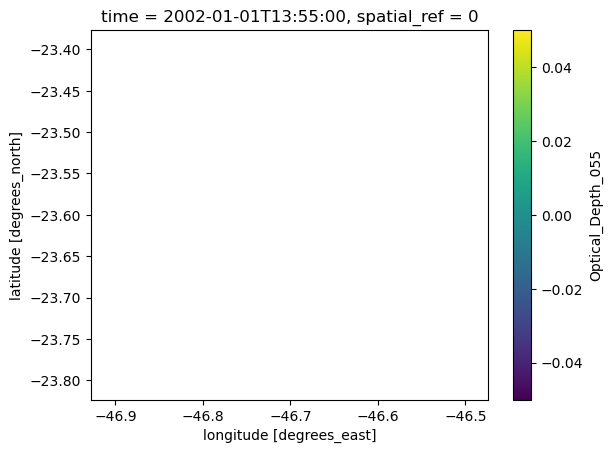

In [90]:
d3 = xr.open_dataset('NETCDF_FOLDER/SP_2002_1.nc')
d3.Optical_Depth_055.isel(time=0).plot()

In [23]:
import salem
import matplotlib.pyplot as plt 

In [25]:
stations = {'SP-EACH':(-46.499670, -23.481630)
            ,'sp': (-46.734983, -23.561500)}


In [21]:
shp = 'SP_Municipios_2023/SP_Municipios_2023.shp'
shape = salem.read_shapefile(shp)
sp = shape[shape['NM_MUN'] == 'São Paulo']

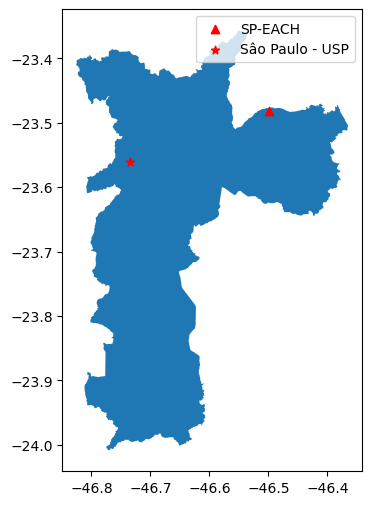

In [38]:
fig, ax = plt.subplots(figsize=(10,6))
sp.plot(ax=ax)
ax.scatter(stations['SP-EACH'][0],stations['SP-EACH'][1],color='r',marker='^',label='SP-EACH')
ax.scatter(stations['sp'][0],stations['sp'][1],color='r',marker='*',label='Sâo Paulo - USP')
ax.legend()